# Finite Huygens' Metasurface with LG Beam

## Initialization

Here we follow the seven steps of initialization I wrote down in the tutorial: 

0. Frequency Range Specification
1. Computational Domain Size
2. Grid Specifications (Discretization size)
3. Structures and Materials
4. Sources
5. Monitors
6. Run time
7. Boundary Condition Specification

## 0 Frequency Range Specification

In [1]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d.components.beam import BeamProfile
from scipy.special import factorial, genlaguerre
import scienceplots

# Set logging level to ERROR to reduce output verbosity
td.config.logging_level = "ERROR"


In [2]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.1, wvl_max=1.6)
N = 301 # num_points
freq0 = fr.freq0
lda0 = td.C_0 / fr.freq0
freqw = fr.fmax - fr.fmin

## 1 Computational Domain Size

In [3]:
# 1 Computational Domain Size
h = 0.220  # Height of cylinder
spc = 2
Lz = spc + h + h + spc

Px = Py = P = 0.666 # periodicity
sim_size = [Px, Py, Lz]

## 2 Grid Resolution

Grid resolution is uniform grid in the horizontal direction with a yee cell length of $\frac{P}{32}$ where $P$ is the periodicity. In the vertical direction, `AutoGrid` means it's non-uniform and adjusted based on the wavelength of the particular medium. Here, `min_steps_per_wvl=32` means we are taking a minimum of 32 steps based on the wavelength, which will be shorter in the medium with a higher index of refraction.

In [4]:
# 2 Grid Resolution
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

## 3 Structures and Materials

**Structures and Materials for the meta-atom**

In [5]:
r = 0.242  # radius of the cylinder
n_Si = 3.5
Si = td.Medium(permittivity=n_Si**2, name='Si')
cylinder = td.Structure(
    geometry=td.Cylinder(center=[0, 0, h / 2], radius=r, length=h, axis=2), medium=Si
)

**Background Medium for Figure 5(a) ($n_1=1.4, n_2=1.45$)**

In [6]:
# Background medium for the first simulation
n_glass = 1.4
n_SiO2 = 1.45
glass = td.Medium(permittivity=n_glass**2, name='glass')
SiO2 = td.Medium(permittivity=n_SiO2**2, name='oxide')

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=SiO2,
    name='substrate'
)

glass = td.Structure(
    geometry=td.Box(
        center=(0,0,Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=glass,
    name='superstrate'
)

**Background Medium for Figure 5(c) ($n=1.66$)**

In [7]:
# Background medium for the second simulation
# Polymer
n_polymer = 1.66
polymer = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(td.inf,td.inf,td.inf)
    ),
    medium=td.Medium(permittivity=n_polymer**2, name='polymer'),
    name='polymer'
)

## 4 The Source

The source is a simple Plane wave that traverses in the -z axis, placed $\frac{\lambda_0}{2}$ distance above the metaatom in the computational domain. Polarization is along the x-axis, that's what `pol_angle=0` means.

In [8]:
source = td.PlaneWave(
    source_time=fr.to_gaussian_pulse(),
    size=(td.inf, td.inf, 0),
    center=(0, 0, Lz/2 - spc + 0.5 * lda0),
    direction="-",
    pol_angle=0
)

## 5 Monitors

**Monitor for Transmittance**

In [9]:
# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, -Lz/2 + spc - 0.5 * lda0], size=[td.inf, td.inf, 0], freqs=fr.freqs(N), name="T"
)

# add a flux monitor to detect reflection
monitor_r = td.FluxMonitor(center=[0, 0, 0.4 * Lz], size=[td.inf, td.inf, 0], freqs=fr.freqs(N), name="R")

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, lda0], freqs=[freq0], name="field"
)

## 6 Run Time

In [10]:
bandwidth = fr.fmax - fr.fmin
run_time_short = 50 / bandwidth # run_time for the transmittance simulation
run_time_long = 200 / bandwidth # run_time for the phase simulation

## 7 Boundary Conditions

We apply PML in the +Z and -Z surfaces.

In [11]:
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

## Helper Function for simulation

Since we have to run simulation two times, it is convenient to abstract out what are the differences to the two simulations and make defining simulations easier. Always follow the [DRY Principle](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself).

In [12]:
def simulation_helper(background, monitors, run_time):
    """
    Create normalization and actual tidy3d simulations, visualize geometry, 
    and return both as a dictionary.

    Parameters
    ----------
    background : list of td.Structure
        Background structures (without the cylinder).
    monitors : list of td.Monitor
        Monitors for the normalization run.
    run_time : float
        Run time for the normalization simulation.

    Returns
    -------
    dict
        {"norm": Simulation without cylinder,
         "actual": Simulation with cylinder}

    Notes
    -----
    Saves cross-sectional plots of the actual simulation (x=0, y=0, z=0) 
    with grid overlay for verification.
    """
    sim_empty=td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=background,
        sources=[source],
        monitors=monitors,
        run_time=run_time,
        boundary_spec=bc
    )

    background.append(cylinder)
    sim_actual = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=background,
        sources=[source],
        monitors=monitors,
        run_time=run_time,
        boundary_spec=bc
    )

    # Always visualize simulation before running
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))
    ax1.tick_params(axis='x', labelsize=7)
    ax2.tick_params(axis='x', labelsize=7)
    sim_actual.plot(x=0, ax=ax1)
    sim_actual.plot_grid(x=0, ax=ax1)
    sim_actual.plot(y=0, ax=ax2)
    sim_actual.plot_grid(y=0, ax=ax2)
    sim_actual.plot(z=0, ax=ax3)
    sim_actual.plot_grid(z=0, ax=ax3)
    plt.savefig(f'huygens_structure_{background[0].name}.png', dpi=300)
    plt.show()

    sims = {
        "norm": sim_empty,
        "actual": sim_actual,
    }

    return sims



## Transmittance Simulation

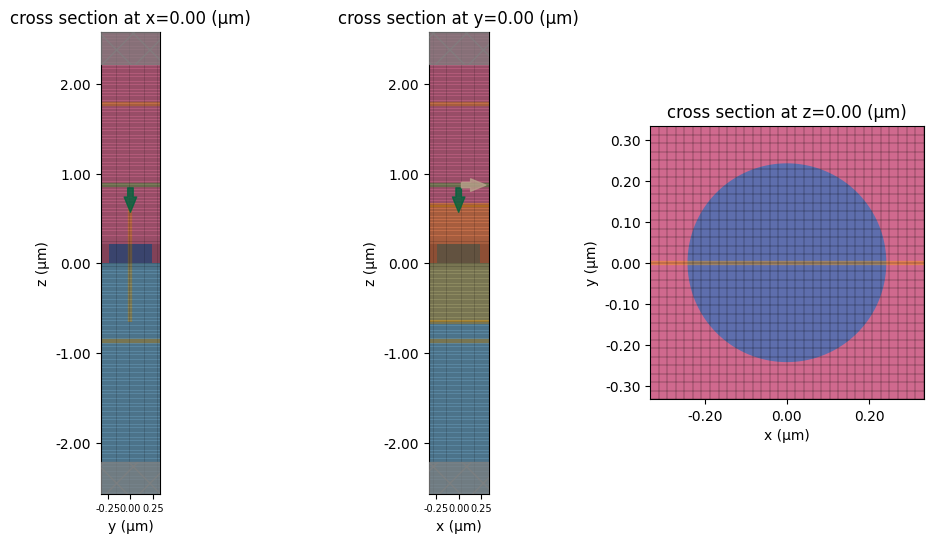

In [13]:
sims = simulation_helper(
    background=[substrate, glass],
    monitors=[monitor_t, monitor_r, monitor_field],
    run_time=run_time_short
)

In [14]:
sims["actual"].plot_3d()

In [15]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/huygens10162025")

/Users/yankunmeng/.local/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

18:15:52 EDT Started working on Batch containing 2 tasks.

18:15:54 EDT Maximum FlexCredit cost: 0.050 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

/Users/yankunmeng/.local/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

KeyboardInterrupt: 

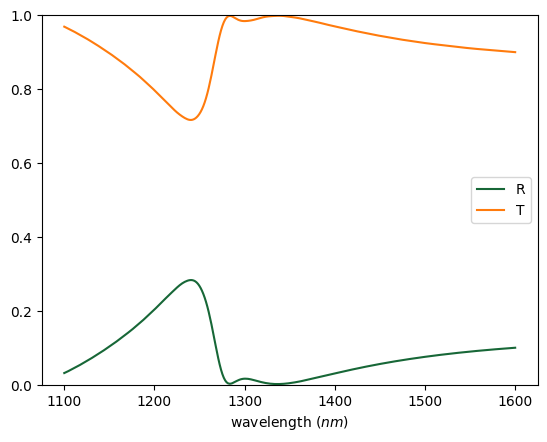

In [ ]:
R = batch_data["actual"]["R"].flux
T = -batch_data["actual"]["T"].flux
x = td.C_0 / fr.freqs(N) * 1000
plt.plot(x, R, x, T)
plt.xlabel("wavelength ($nm$)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()

# Finite Huygens

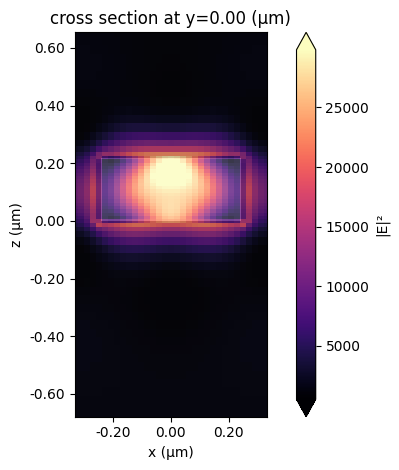

In [ ]:
batch_data["actual"].plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()

In [22]:
Nx = 15  # number of unit cells in the x direction
Ny = 15  # number of unit cells in the y direction
buffer = 0.5 * lda0  # buffer spacing in the x and y directions

# simulation domain size
Lx, Ly, Lz = Nx * P + 2 * buffer, Ny * P + 2 * buffer, 2 * lda0
sim_size = [Lx, Ly, Lz]

In [23]:
# systematically construct the silicon resonators
metasurface = [substrate]
for i in range(Nx):
    for j in range(Ny):
        cylinder = td.Structure(
            geometry=td.Cylinder(center=[i * P, j * P, h / 2], radius=r, length=h, axis=2),
            medium=Si,
        )
        metasurface.append(cylinder)

In [24]:
# define a gaussian beam with a waist radius of 3 wavelengths (focused beam)
gaussian = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    center=(P * (Nx // 2), P * (Ny // 2), 0.3 * lda0),
    direction="-",
    waist_radius=3 * lda0,
)

In [25]:

# define a field monitor to visualize the field distribution under gaussian beam excitation
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)


In [26]:
# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, - 0.5 * lda0], size=[td.inf, td.inf, 0], freqs=fr.freqs(N), name="T"
)

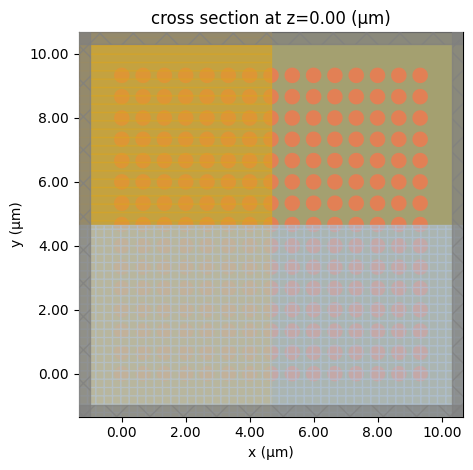

In [ ]:
sim = td.Simulation(
    size=sim_size,
    center=(P * (Nx // 2), P * (Ny // 2), 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=metasurface,
    sources=[gaussian],
    monitors=[
        monitor_t,
        monitor_r,
        monitor_field,
    ],  # we will reuse the flux monitors defined earlier
    run_time=run_time_long,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # pml is applied in all boundaries
    symmetry=(-1, 1, 0),
)  # the same symmetry can be used

sim.plot_3d()
sim.plot(z=0)
plt.show()

In [ ]:
sim_data = web.run(
    sim,
    task_name="huygens_metasurface_absorber_2",
    path="data/simulation_finite_3d.hdf5",
    verbose=True,
)

18:12:19 EDT Created task 'huygens_metasurface_absorber_2' with task_id         
             'fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=233805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=963281;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\taskId]8;;\]8;id=233805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\=]8;;\]8;id=895368;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\fdve]8;;\]8;id=233805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\-6d79b2cd-c45]8;;\
             ]8;id=233805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\d-48bd-b93b-0dd900ce6c65']8;;\.

             Task folder: ]8;id=315191;https://tidy3d.simulation.cloud/folders/folder-4a96f49a-40a0-4d85-a7de-71d7af0d2c31\'default']8;;\.

/Users/yankunmeng/.local/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

18:12:21 EDT Maximum FlexCredit cost: 0.826. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:12:22 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

18:12:33 EDT status = preprocess

18:12:37 EDT starting up solver

             running solver

18:13:30 EDT early shutoff detected at 64%, exiting.

             status = postprocess

18:13:32 EDT status = success

18:13:34 EDT View simulation result at                                          
             ]8;id=615738;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=271354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\taskId]8;;\]8;id=615738;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\=]8;;\]8;id=979004;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\fdve]8;;\]8;id=615738;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\-6d79b2cd-c45]8;;\
             ]8;id=615738;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d79b2cd-c45d-48bd-b93b-0dd900ce6c65\d-48bd-b93b-0dd900ce6c65']8;;\.

18:13:36 EDT loading simulation from data/simulation_finite_3d.hdf5

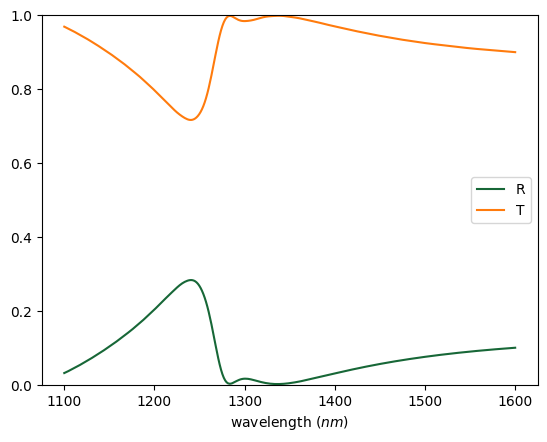

In [ ]:
R = batch_data["actual"]["R"].flux
T = -batch_data["actual"]["T"].flux
x = td.C_0 / fr.freqs(N) * 1000
plt.plot(x, R, x, T)
plt.xlabel("wavelength ($nm$)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()

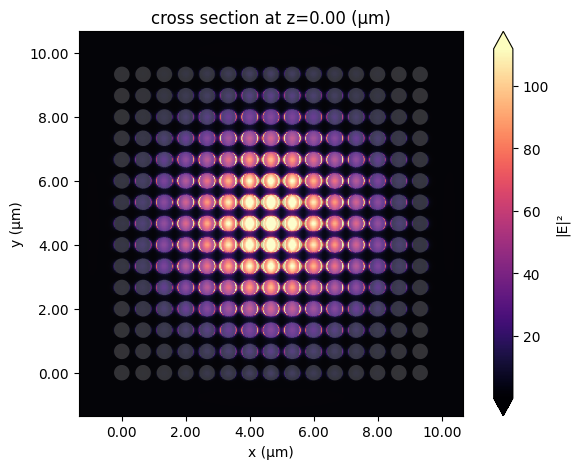

In [73]:
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.savefig("huygens_gaussian.png", dpi=300)
plt.show()

#

## LG Beam

In [27]:
def OAM(
    size,
    p, # radial index
    l, # azimuthal index
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    freqs = [source_time.freq0]

    class OAM_obj(BeamProfile):
        """Component for constructing OAM beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for OAM beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y, x)
            absl = np.abs(l)

            zR = np.pi * background_n * w0**2 / (td.C_0 / np.array(self.freqs))
            wz = w0 * np.sqrt(1 + z**2 / zR**2)
            Rz = td.inf if np.any(z == 0) else z * (1 + zR**2 / z**2)
            k = 2 * np.pi * np.array(self.freqs) / td.C_0 * background_n
            psi_z = (np.abs(l) + 2 * p + 1) * np.arctan2(z, np.real(zR))

            E = genlaguerre(p, absl)(2 * r**2 / wz**2) if p != 0 else 1
            E *= (
                source_time.amplitude
                * np.sqrt(2 * factorial(p) / (np.pi * factorial(p + absl)))
                / wz
            )
            E *= (r * np.sqrt(2) / wz) ** absl * np.exp(-(r**2) / wz**2)
            E *= np.exp(-1j * k * r**2 / (2 * Rz)) * np.exp(-1j * l * phi) * np.exp(1j * psi_z)

            return E

    OAM_obj = OAM_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = OAM_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    OAM_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return OAM_source

In [58]:
oam = OAM(
    size=(Lx / 2, Ly / 2, 0),                       # same planar extent
    p=0,                                            # radial index
    l=1,                                            # azimuthal index
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    center=(P * (Nx // 2), P * (Ny // 2), 0.3 * lda0),  # same center
    direction="-",                                  # same propagation direction
    w0=3 * lda0,                                    # same waist radius
    waist_distance=0                                # same focusing plane (z = waist)
)

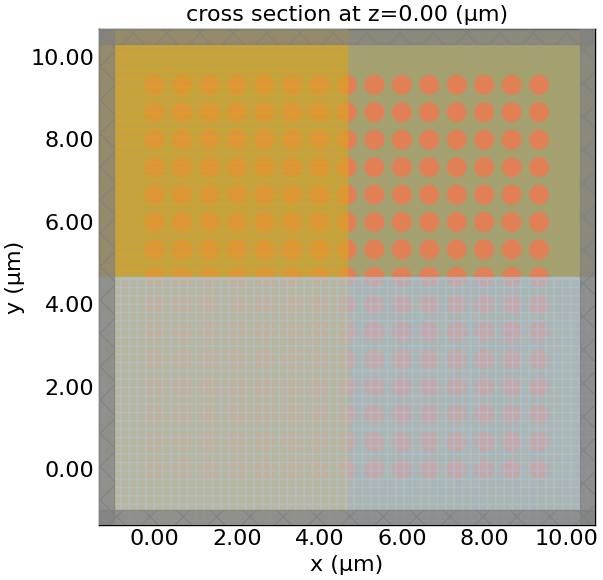

In [59]:
sim = td.Simulation(
    size=sim_size,
    center=(P * (Nx // 2), P * (Ny // 2), 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=metasurface,
    sources=[oam],
    monitors=[
        monitor_t,
        monitor_field,
    ],  # we will reuse the flux monitors defined earlier
    run_time=run_time_long,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # pml is applied in all boundaries
    symmetry=(-1, 1, 0),
)  # the same symmetry can be used

sim.plot_3d()
sim.plot(z=0)
plt.show()

In [60]:
sim_data = web.run(
    sim,
    task_name="huygens_metasurface_absorber_lg01",
    path="data/simulation_finite_lg01.hdf5",
    verbose=True,
)

18:33:54 EDT Created task 'huygens_metasurface_absorber_lg01' with task_id      
             'fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=829631;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=625681;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\taskId]8;;\]8;id=829631;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\=]8;;\]8;id=32100;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\fdve]8;;\]8;id=829631;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\-36b5aaf2-df2]8;;\
             ]8;id=829631;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\2-4287-bda0-32fe305c52d2']8;;\.

             Task folder: ]8;id=21359;https://tidy3d.simulation.cloud/folders/folder-4a96f49a-40a0-4d85-a7de-71d7af0d2c31\'default']8;;\.

/Users/yankunmeng/.local/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

18:33:56 EDT Maximum FlexCredit cost: 0.689. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:33:57 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

18:34:06 EDT starting up solver

             running solver

18:35:36 EDT early shutoff detected at 68%, exiting.

             status = postprocess

18:35:38 EDT status = success

18:35:40 EDT View simulation result at                                          
             ]8;id=201205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=756266;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\taskId]8;;\]8;id=201205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\=]8;;\]8;id=364671;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\fdve]8;;\]8;id=201205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\-36b5aaf2-df2]8;;\
             ]8;id=201205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36b5aaf2-df22-4287-bda0-32fe305c52d2\2-4287-bda0-32fe305c52d2']8;;\.

18:35:48 EDT loading simulation from data/simulation_finite_lg01.hdf5

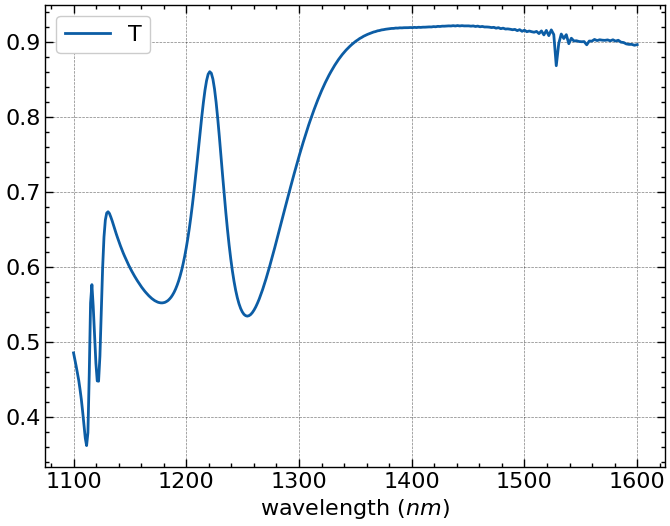

In [61]:
T = -sim_data["T"].flux
x = td.C_0 / fr.freqs(N) * 1000
plt.plot(x, T)
plt.xlabel("wavelength ($nm$)")
plt.legend("T")
plt.show()

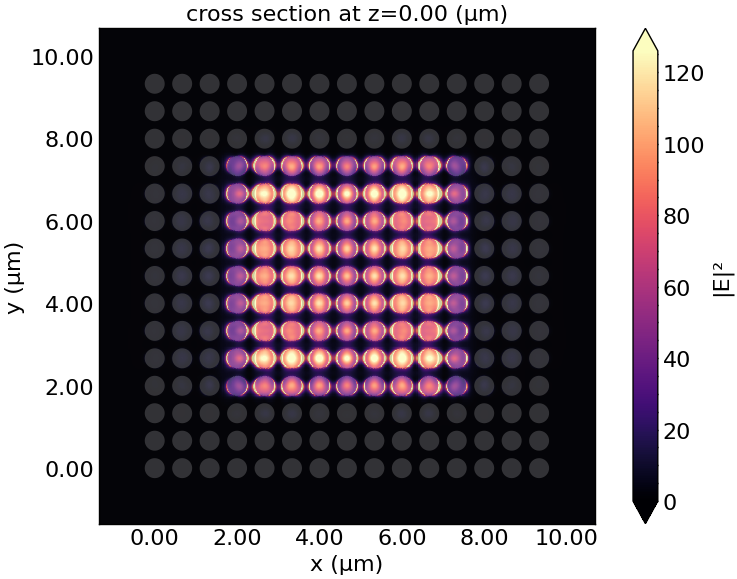

In [62]:
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.savefig("huygens_lg_gaussian.png", dpi=300)
plt.show()

## Transmittance Results

In [17]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
T = batch_data["actual"]["flux_monitor"].flux / batch_data["norm"]["flux_monitor"].flux

NameError: name 'batch_data' is not defined

NameError: name 'T' is not defined

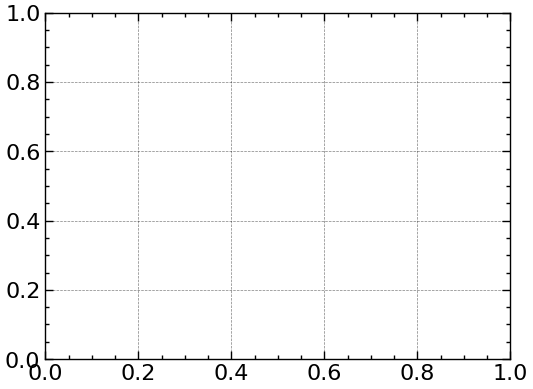

In [ ]:
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, np.abs(T, "r", lw=1, label="T")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Transmittance")
plt.ylim(0, 1)
plt.legend()
plt.show()

## Phase Simulation

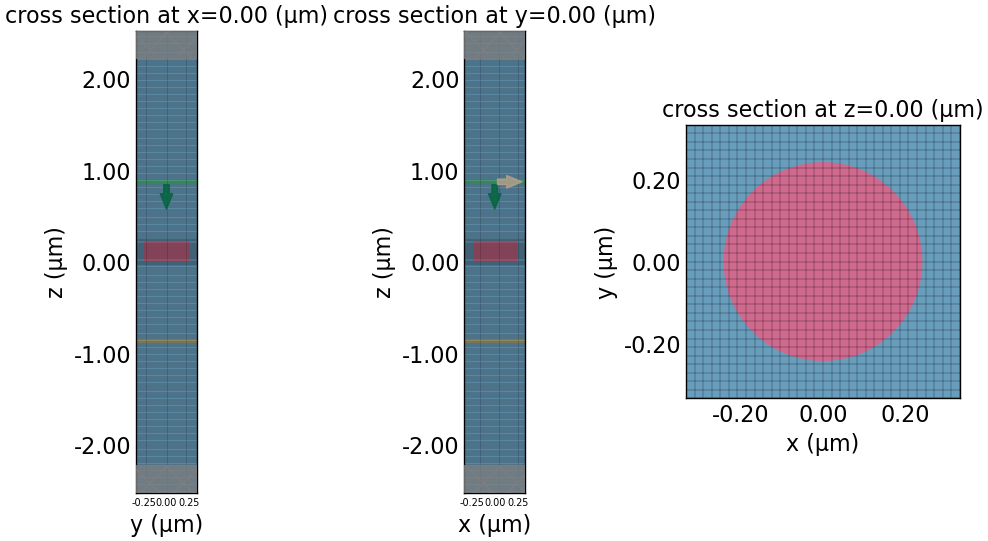

In [92]:
sims = simulation_helper(
    background=[polymer],
    monitors=[field_monitor],
    run_time=run_time_long
)

In [93]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/huygens5c")

Output()

02:21:11 EDT Started working on Batch containing 2 tasks.

02:21:13 EDT Maximum FlexCredit cost: 0.050 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

02:21:14 EDT Batch complete.

Output()

## Phase Results

In [94]:
# Data Extraction
Ex_actual = batch_data["actual"]["field_monitor"].Ex 
Ex_norm = batch_data["norm"]["field_monitor"].Ex
Ex = Ex_actual / Ex_norm

In [95]:
# 1. Compute average over the xy-plane
Ex_avg = np.mean(Ex[:, :, 0, :], axis=(0,1))

# 2. Compute phase
phase_avg = np.angle(Ex_avg)

# 3. Unwrap phase to remove ±pi jumps
phase_avg_unwrapped = np.unwrap(phase_avg)

# 4. Make relative to first point (optional)
phase_rel = phase_avg_unwrapped - phase_avg_unwrapped[0]

phase_actual = np.unwrap(np.angle(np.mean(Ex_actual[:, :, 0, :], axis=(0,1))))
phase_norm = np.unwrap(np.angle(np.mean(Ex_norm[:, :, 0, :], axis=(0,1))))

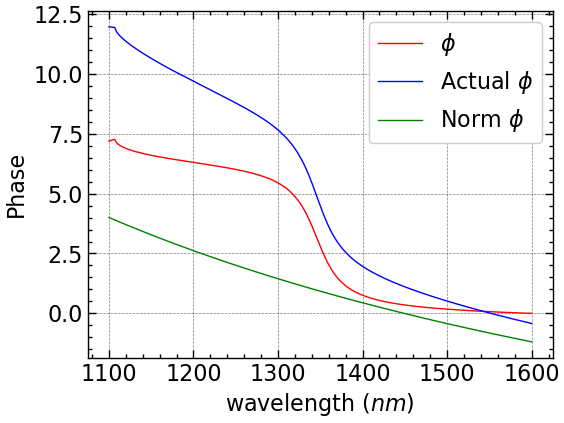

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_rel, "r", lw=1, label="$\phi$")
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_actual, "b", lw=1, label="Actual $\phi$")
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_norm, "g", lw=1, label="Norm $\phi$")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Phase")
plt.legend()
plt.show()

## Final Plotting

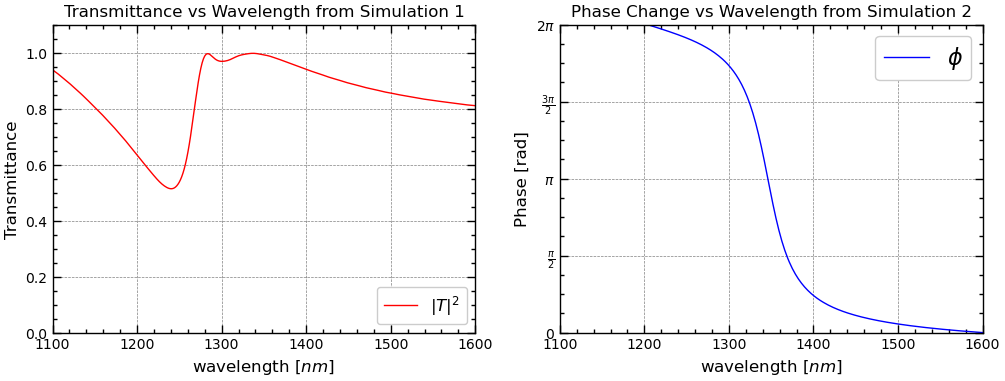

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# work on the first figure
ax = axes[0]
ax.tick_params(axis="both", labelsize=10)
ax.plot(td.C_0 / fr.freqs(N) * 1000, np.abs(T)**2, "r", lw=1, label="$|T|^2$")
ax.set_xlabel(r"wavelength [$nm$]", fontsize=12)
ax.set_ylabel("Transmittance", fontsize=12)
ax.set_title("Transmittance vs Wavelength from Simulation 1", fontsize=12)
ax.set_xlim(1100, 1600)
ax.set_ylim(0, 1.1)
ax.legend(loc="lower right", fontsize=12)

# work on the second figure
ax = axes[1]
ax.tick_params(axis="both", labelsize=10)
ax.plot(td.C_0 / fr.freqs(N) * 1000, phase_rel, "b", lw=1, label="$\phi$")
ax.set_xlabel(r"wavelength [$nm$]", fontsize=12)
ax.set_ylabel("Phase [rad]", fontsize=12)
ax.set_title("Phase Change vs Wavelength from Simulation 2", fontsize=12)
ax.set_xlim(1100, 1600)
ax.set_ylim(0, np.pi*2)
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
ytick_labels = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", 
                r"$\frac{3\pi}{2}$", r"$2\pi$"]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.legend()

plt.savefig("huygens.png", dpi=300)

## Mesh Study

Here, we set out to study the effect of different yee cell length on the transmittance. 

In [98]:
dls = [P/2, P/4, P/8, P/16, P/32, P/64, P/128] # mesh study list
sims = {}

In [99]:
# for each dl in dls
for i, dl in enumerate(dls):
    # 2 Grid Specifications
    horizontal_grid = td.UniformGrid(dl=dl)
    vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
    grid_spec=td.GridSpec(
        grid_x=horizontal_grid,
        grid_y=horizontal_grid,
        grid_z=vertical_grid,
    )

    # 4 Sources
    source = td.PlaneWave(
        source_time=fr.to_gaussian_pulse(),
        size=(td.inf, td.inf, 0),
        center=(0, 0, Lz/2 - spc + 2 * dl),
        direction="-",
        pol_angle=0
    )

    # 5 Monitor
    monitor = td.FluxMonitor(
        center=(0, 0, -Lz/2 + spc - 2*dl),
        size=(td.inf, td.inf, 0),
        freqs=fr.freqs(N),
        name="flux"
    )

    sim_empty=td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, glass],
        sources=[source],
        monitors=[monitor],
        run_time=run_time_short,
        boundary_spec=bc
    )

    sim_actual = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, glass, cylinder],
        sources=[source],
        monitors=[monitor],
        run_time=run_time_short,
        boundary_spec=bc
    )

    sims[f"norm{i}"] = sim_empty
    sims[f"actual{i}"] = sim_actual  

In [100]:
# verify the sims dictionary
print(sims.keys())
batch = web.Batch(simulations=sims, verbose=True)

dict_keys(['norm0', 'actual0', 'norm1', 'actual1', 'norm2', 'actual2', 'norm3', 'actual3', 'norm4', 'actual4', 'norm5', 'actual5', 'norm6', 'actual6'])


In [101]:
# run the simulations
batch_data = batch.run(path_dir="data")

Output()

02:21:47 EDT Started working on Batch containing 14 tasks.

02:21:59 EDT Maximum FlexCredit cost: 0.392 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

02:22:21 EDT Batch complete.

Output()

## Mesh Study Results

In [104]:
# Extract results
x = td.C_0 / fr.freqs(N) * 1000
Ts = []
for i in range(len(dls)):
    Ts.append(batch_data[f"actual{i}"]["flux"].flux / batch_data[f"norm{i}"]["flux"].flux)

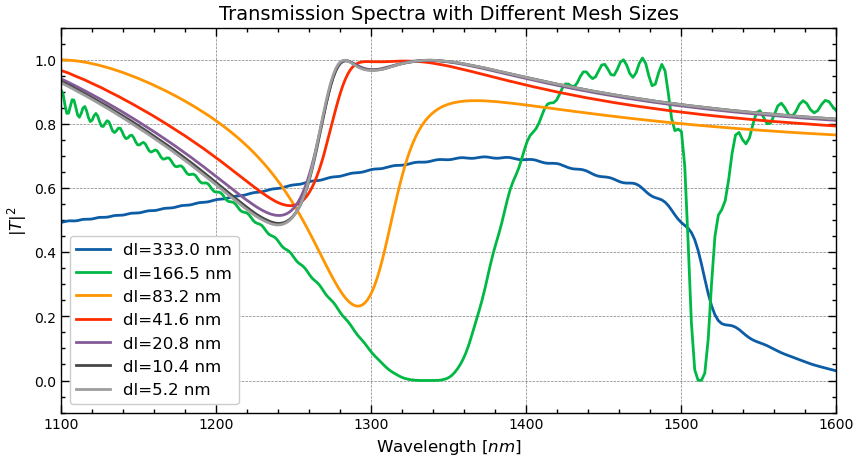

In [107]:
# Plot results
plt.figure(figsize=(10, 5))
for i, T in enumerate(Ts):
    plt.plot(x, np.abs(T)**2, "-",lw=2, label=f"dl={dls[i] * 1000:.1f} nm")
plt.xlabel(r"Wavelength [$nm$]", fontsize=12)
plt.ylabel(r"$|T|^2$", fontsize=12)
plt.xlim(1100, 1600)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=10) # change tick label size to 10
plt.title("Transmission Spectra with Different Mesh Sizes", fontsize=14)
plt.savefig("mesh_convergence.png", dpi=300)
plt.show()

In [1]:
import tidy3d
print(tidy3d.__version__)

2.9.1
